In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
train = np.array(df_train)
test = np.array(df_test)

data_train = np.zeros((180, 22, 81))

for i in range(180):
    data_train[i] = np.moveaxis(train[i*81:(i+1)*81], 0, 1)
    
data_train_labels = data_train[:, 1, 0]
data_train_labels_01 = ~(data_train_labels == 1)
data_train_labels_01 = data_train_labels_01.astype('int')

data_train = data_train[:, 3:, :]

data_test = np.zeros((120, 21, 81))

for i in range(120):
    data_test[i] = np.moveaxis(test[i*81:(i+1)*81], 0, 1)
    
data_test = data_test[:, 2:, :]

In [24]:
data_test.shape

(120, 19, 81)

In [ ]:
# data_xxxx files contains epochs (n_epochs * n_channels * n_timesteps)

# EEGNet

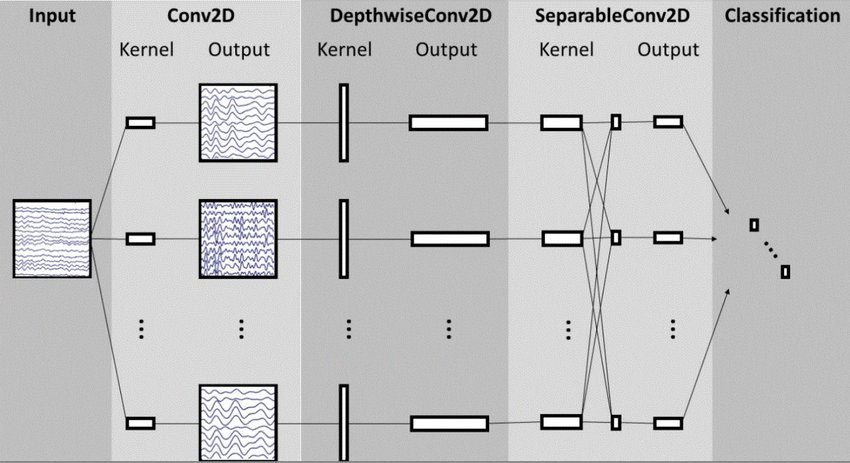

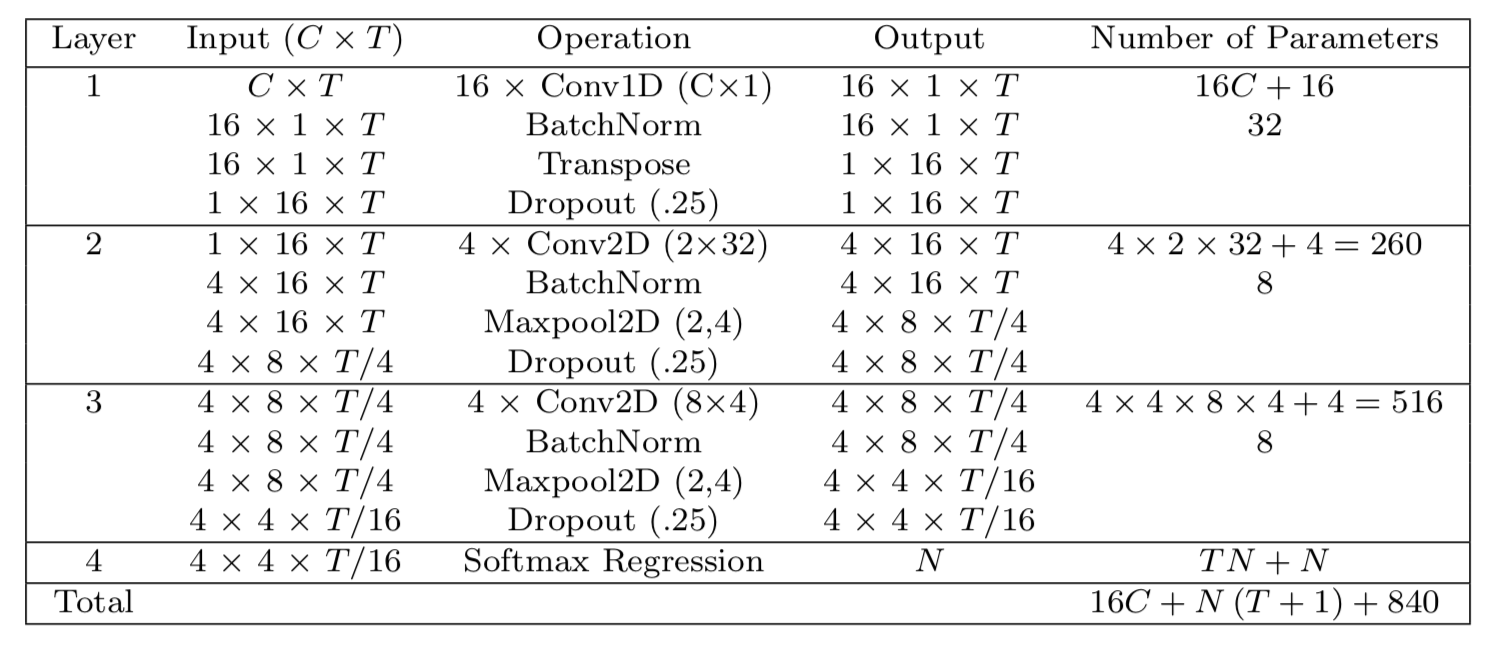

In [4]:
# prepaired data

data_train 
data_train_labels_01

data_test

array([[[-9.13012739e+00,  1.93926657e+00,  1.12706012e+01, ...,
          3.84780227e+01,  3.18564283e+01,  1.73182085e+01],
        [-1.42251341e+01, -5.25870459e+00,  2.33024172e+00, ...,
          4.62691685e+01,  3.99733884e+01,  2.53849741e+01],
        [-5.57098202e+00,  1.38507842e-01,  6.41220728e+00, ...,
          3.64168370e+01,  3.55655383e+01,  2.35246731e+01],
        ...,
        [ 1.62353796e+01,  1.19489979e+01,  1.20813675e+01, ...,
         -1.04600488e+01, -2.02735666e+01, -2.36438918e+01],
        [ 1.49464614e+01,  1.75054085e+01,  2.18294690e+01, ...,
          2.59457669e+01,  6.38740624e+01,  7.76335671e+01],
        [ 2.41475214e+01,  1.98280487e+01,  2.00534400e+01, ...,
          2.46441564e+00,  2.59840064e+01,  3.19910565e+01]],

       [[-5.34387917e+00, -1.50758436e+01, -8.73730185e+00, ...,
          8.09295293e-01, -1.66115281e-01, -6.66003149e+00],
        [-4.09085272e+00, -1.69372833e+01, -1.00481992e+01, ...,
          5.56614442e+00,  4.43475416e

In [5]:
class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()
        self.T = 81
        
        # Layer 1
        self.conv1 = nn.Conv2d(1, 16, (1, 19), padding = 0)
        self.batchnorm1 = nn.BatchNorm2d(16, False)
        
        # Layer 2
        self.padding1 = nn.ZeroPad2d((16, 17, 0, 1))
        self.conv2 = nn.Conv2d(1, 4, (2, 32))
        self.batchnorm2 = nn.BatchNorm2d(4, False)
        self.pooling2 = nn.MaxPool2d(2, 4)
        
        # Layer 3
        self.padding2 = nn.ZeroPad2d((2, 1, 4, 3))
        self.conv3 = nn.Conv2d(4, 4, (8, 4))
        self.batchnorm3 = nn.BatchNorm2d(4, False)
        self.pooling3 = nn.MaxPool2d((2, 4))
        
        # FC Layer
        # NOTE: This dimension will depend on the number of timestamps per sample in your data.
        # I have 120 timepoints. 
        self.fc1 = nn.Linear(40, 1)
        

    def forward(self, x):
        # Layer 1
        x = F.elu(self.conv1(x))
        x = self.batchnorm1(x)
        x = F.dropout(x, 0.1)
        x = x.permute(0, 3, 1, 2)
        
        # Layer 2
        x = self.padding1(x)
        x = F.elu(self.conv2(x))
        x = self.batchnorm2(x)
        x = F.dropout(x, 0.1)
        x = self.pooling2(x)
        
        # Layer 3
        x = self.padding2(x)
        x = F.elu(self.conv3(x))
        x = self.batchnorm3(x)
        x = F.dropout(x, 0.1)
        x = self.pooling3(x)
        
        # FC Layer
        x = x.view(-1, 40)
        x = torch.sigmoid(self.fc1(x))
        return x

In [6]:
def evaluate(model, X, Y, params = ["acc"]):
    results = []
    batch_size = 3
    
    predicted = []
    
    for i in range(int(len(X)/batch_size)):
        s = i*batch_size
        e = i*batch_size+batch_size
        
        inputs = Variable(torch.from_numpy(X[s:e]))
        pred = model(inputs)
        
        predicted.append(pred.data.cpu().numpy())
        
        
    inputs = Variable(torch.from_numpy(X))
    predicted = model(inputs)
    
    predicted = predicted.data.cpu().numpy()
    
    for param in params:
        if param == 'acc':
            results.append(accuracy_score(Y, np.round(predicted)))
        if param == "auc":
            results.append(roc_auc_score(Y, predicted))
        if param == "recall":
            results.append(recall_score(Y, np.round(predicted)))
        if param == "precision":
            results.append(precision_score(Y, np.round(predicted)))
        if param == "fmeasure":
            precision = precision_score(Y, np.round(predicted))
            recall = recall_score(Y, np.round(predicted))
            results.append(2*precision*recall/ (precision+recall))
    return results

In [7]:
X_train = np.expand_dims(np.moveaxis(data_train, 1, 2), 1).astype('float32') 
y_train = data_train_labels_01.astype('float32')

In [8]:
net = EEGNet()
print(net.forward(Variable(torch.Tensor(np.random.rand(1, 1, 81, 19)))))
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters())

tensor([[0.8901]], grad_fn=<SigmoidBackward0>)


In [9]:
batch_size = 3

for epoch in range(5):  # loop over the dataset multiple times
    print("\nEpoch ", epoch)
    
    running_loss = 0.0
    for i in range(int(len(X_train)/batch_size)-1):
        s = i*batch_size
        e = i*batch_size+batch_size
        
        inputs = torch.from_numpy(X_train[s:e])
        labels = torch.FloatTensor(np.array([y_train[s:e]]).T*1.0)
        
        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        
        optimizer.step()
        
        running_loss += loss.data#[0]
    
    # Validation accuracy
    params = ["acc", "auc", "fmeasure"]
    print(params)
    print("Training Loss ", running_loss)
    print("Train - ", evaluate(net, X_train, y_train, params))


Epoch  0
['acc', 'auc', 'fmeasure']
Training Loss  tensor(44.1780)
Train -  [0.6444444444444445, 0.6645679012345679, 0.6444444444444445]

Epoch  1
['acc', 'auc', 'fmeasure']
Training Loss  tensor(38.6659)
Train -  [0.7444444444444445, 0.7795061728395063, 0.75]

Epoch  2
['acc', 'auc', 'fmeasure']
Training Loss  tensor(36.1963)
Train -  [0.7611111111111111, 0.8339506172839506, 0.7724867724867724]

Epoch  3
['acc', 'auc', 'fmeasure']
Training Loss  tensor(33.2645)
Train -  [0.7611111111111111, 0.8439506172839506, 0.774869109947644]

Epoch  4
['acc', 'auc', 'fmeasure']
Training Loss  tensor(31.0294)
Train -  [0.8, 0.8908641975308643, 0.8144329896907216]


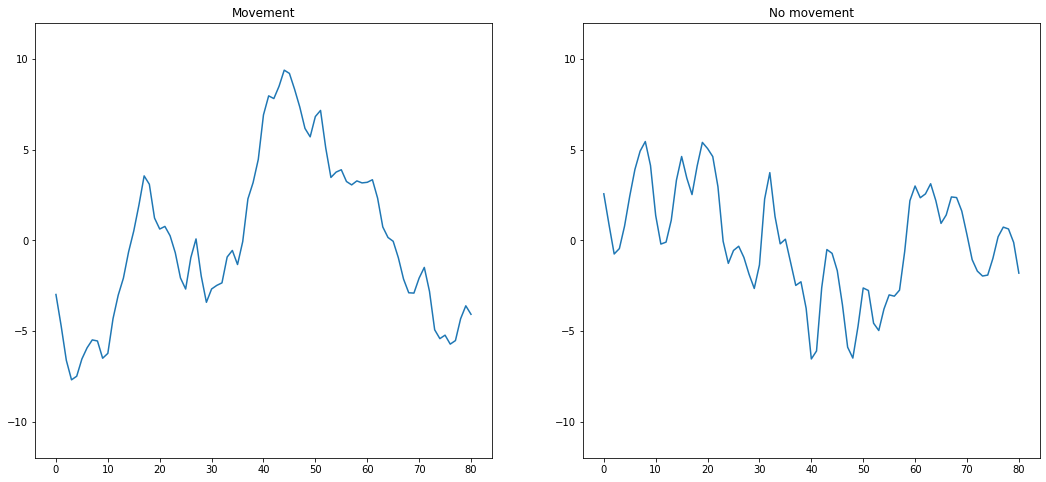

In [10]:
X_test = np.expand_dims(np.moveaxis(data_test, 1, 2), 1).astype('float32')
predicted = net(torch.from_numpy(X_test))

figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
axes[0].plot(np.mean(X_test[np.round(predicted.data.cpu().numpy()).ravel() == 1, 0, :, 8], axis=0))
axes[1].plot(np.mean(X_test[np.round(predicted.data.cpu().numpy()).ravel() == 0, 0, :, 8], axis=0))
axes[0].set_title('Movement')
axes[1].set_title("No movement")
axes[0].set_ylim(-12, 12)
axes[1].set_ylim(-12, 12)
plt.show()

Dropout, PyTorch
<br>In PyTorch there are F.dropout(x, p=p) and layer nn.Dropout(p=p):
<br>1. F.dropout(x, p=p) will not change behavior depending on model state (train, eval)
<br>2. nn.Dropout(p=p) will randomly drop some inputs in train state and do nothing in eval state

We use F.dropout in the network so in eval state our network will also dropout some neurons. Let's rerun prediction for each epoch 1000 times and average predictions for more reliable result.

In [15]:
var_predicted = np.zeros((1000, 120))

for i in range(1000):
    var_predicted[i] = (net(torch.from_numpy(X_test))).detach().numpy().ravel() 

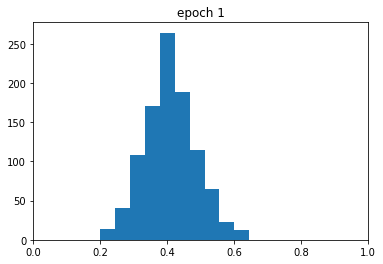

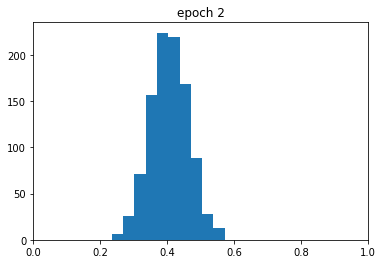

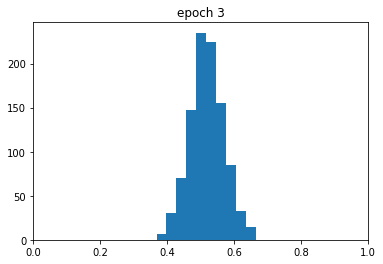

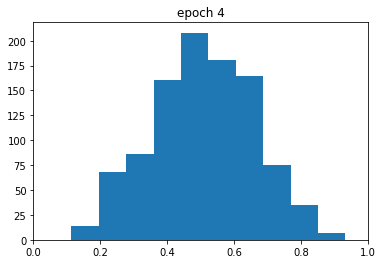

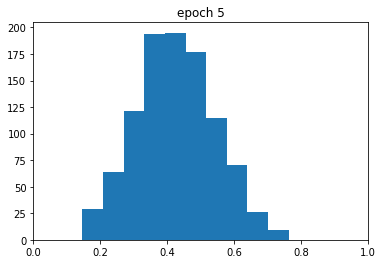

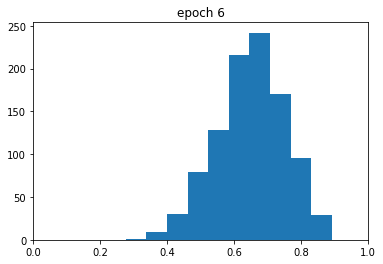

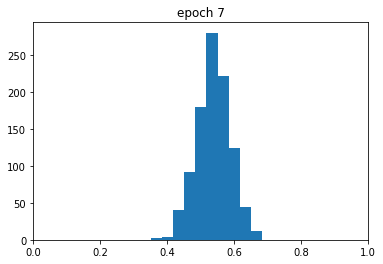

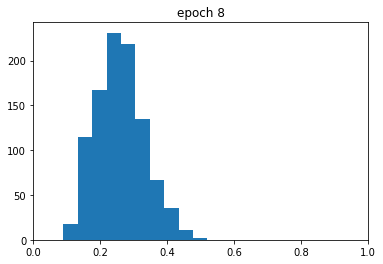

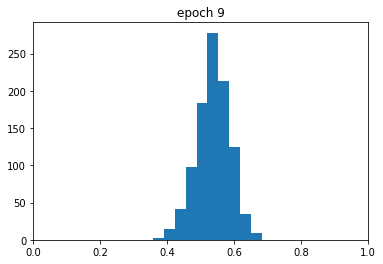

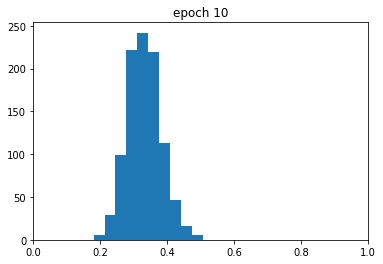

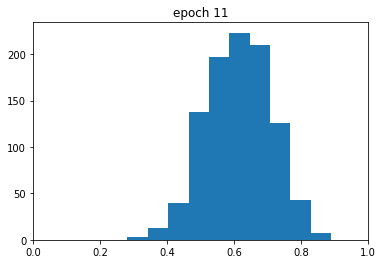

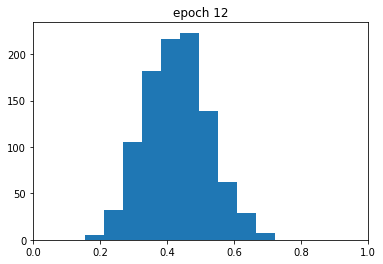

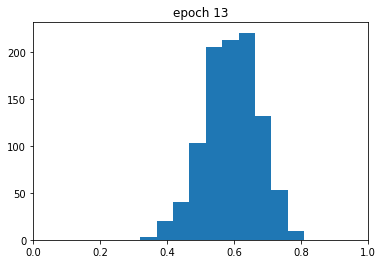

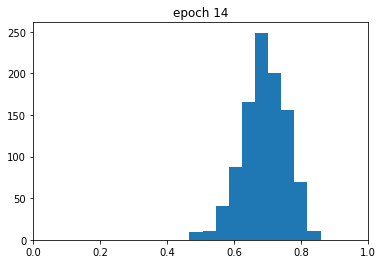

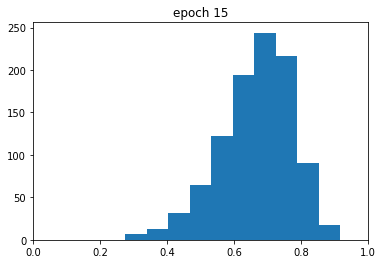

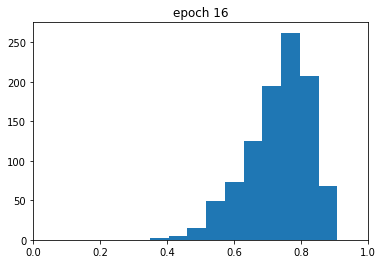

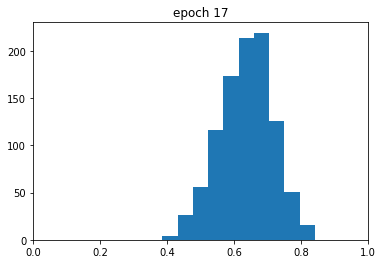

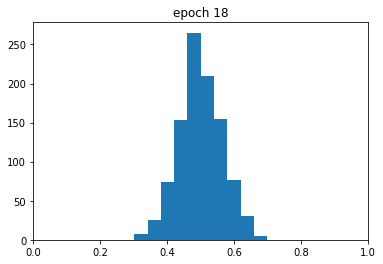

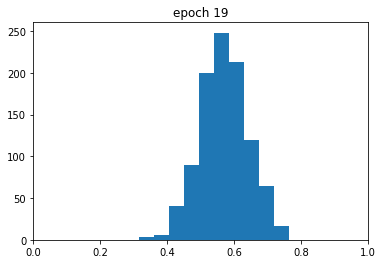

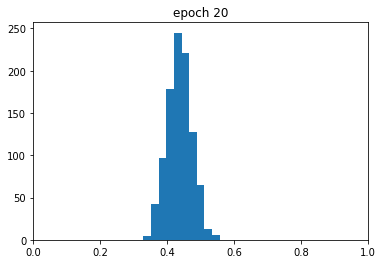

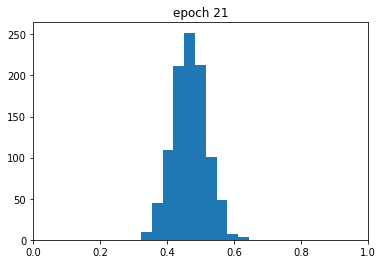

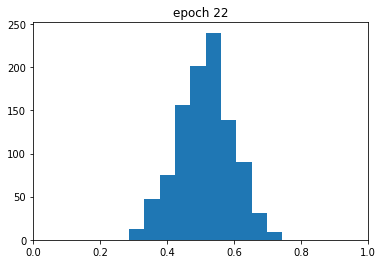

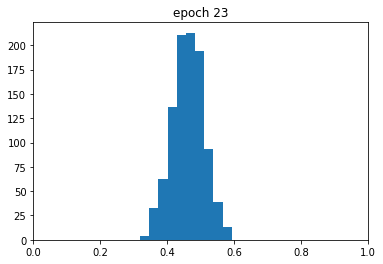

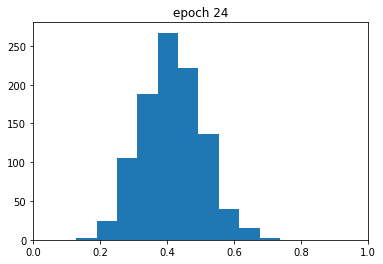

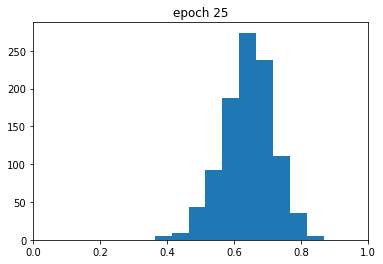

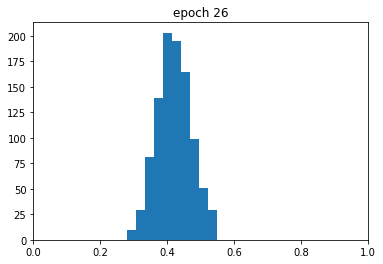

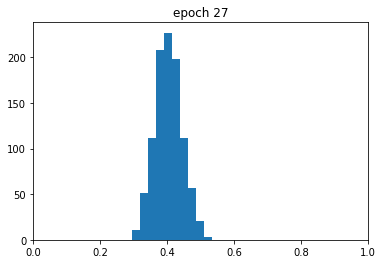

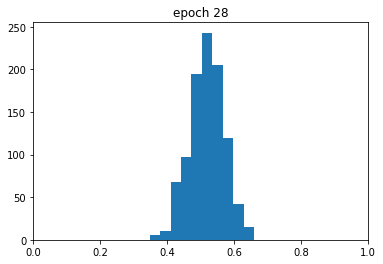

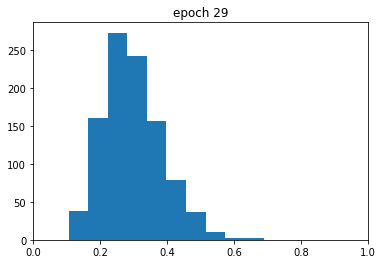

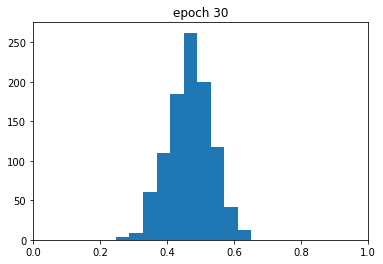

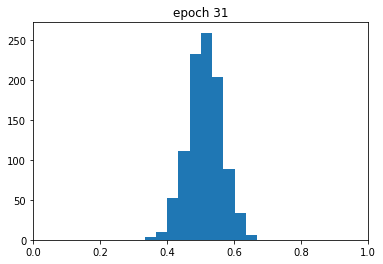

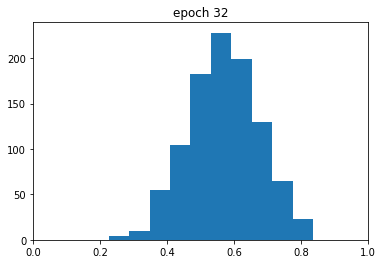

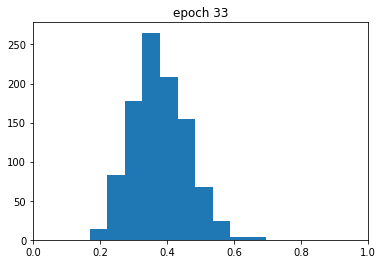

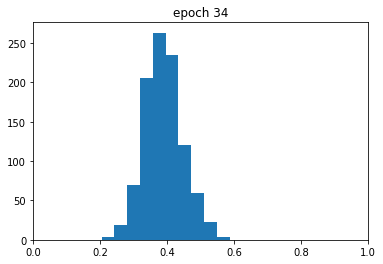

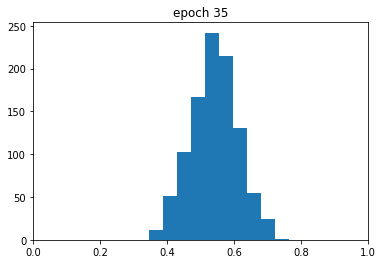

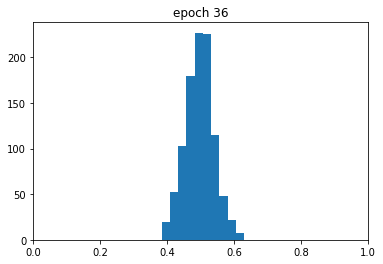

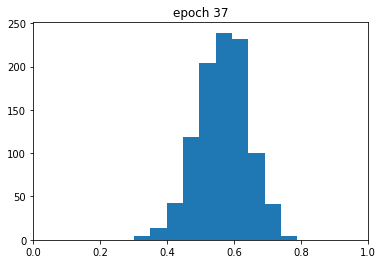

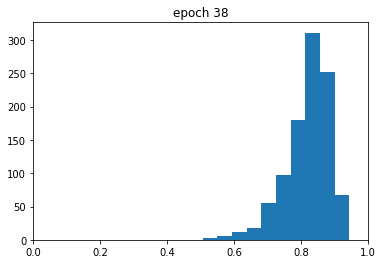

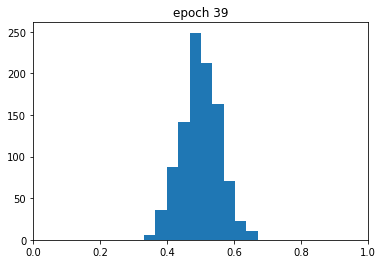

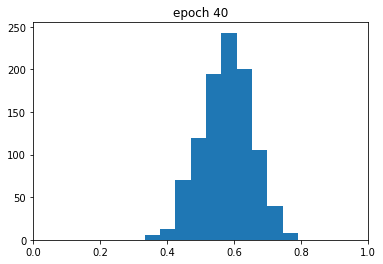

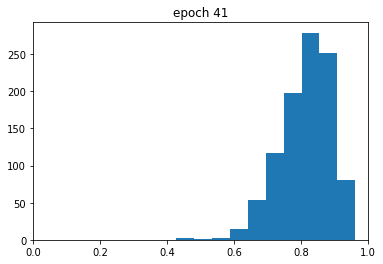

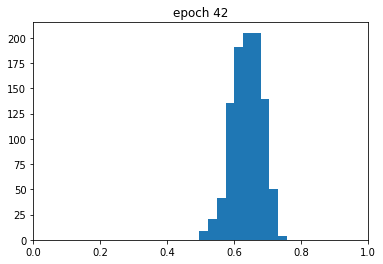

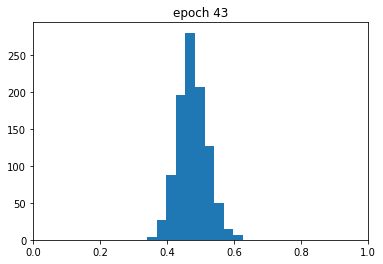

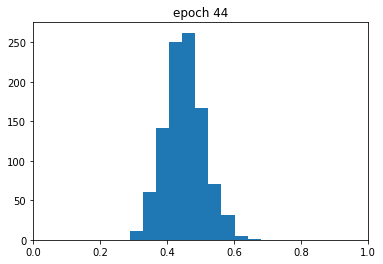

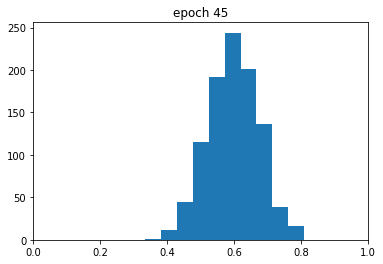

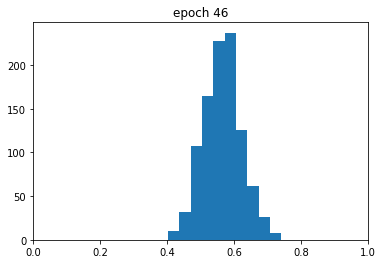

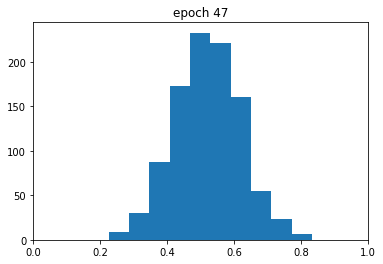

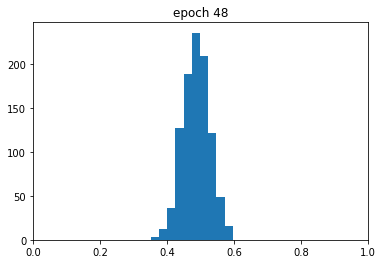

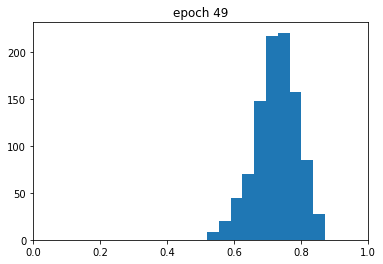

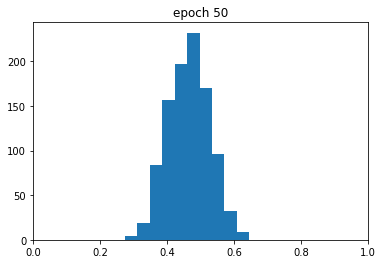

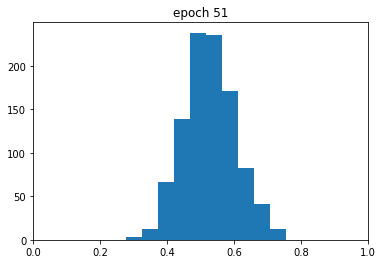

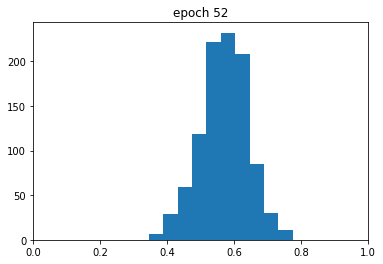

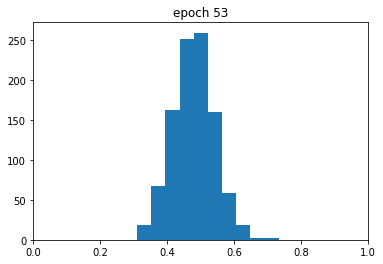

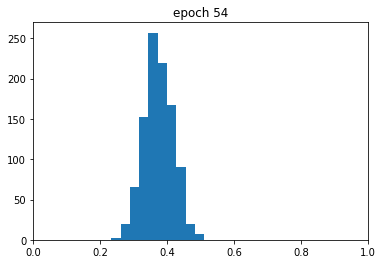

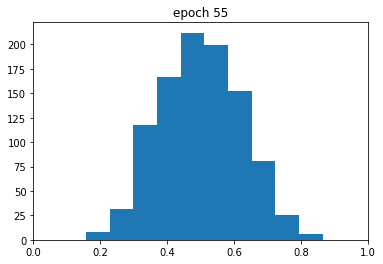

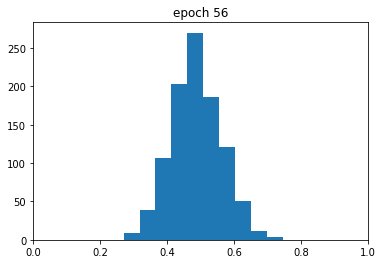

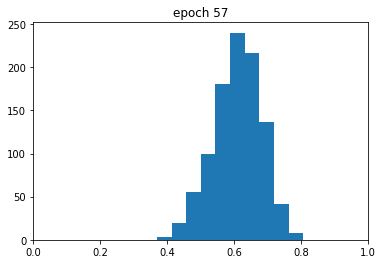

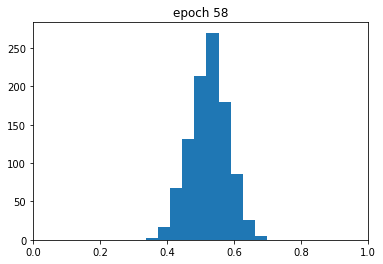

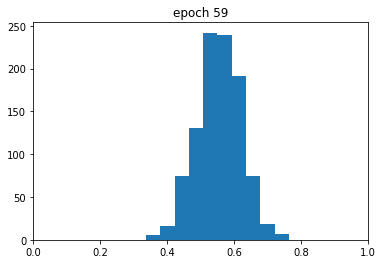

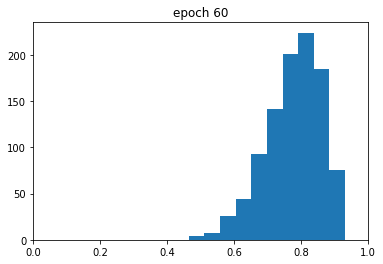

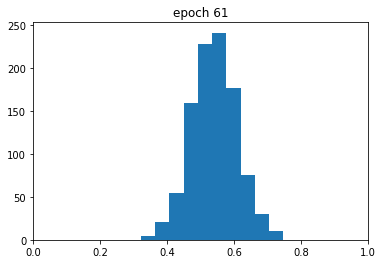

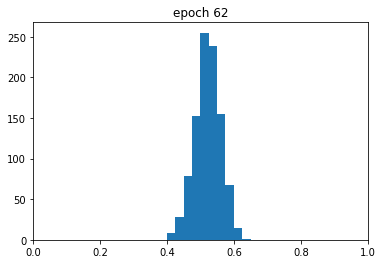

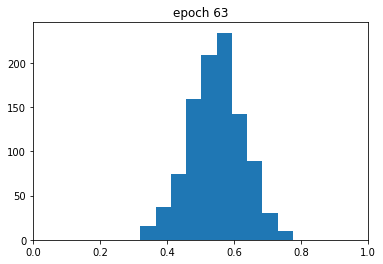

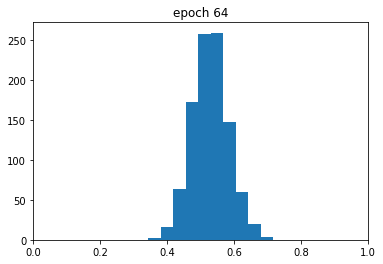

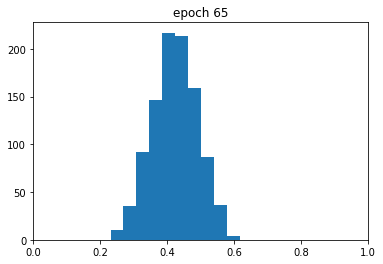

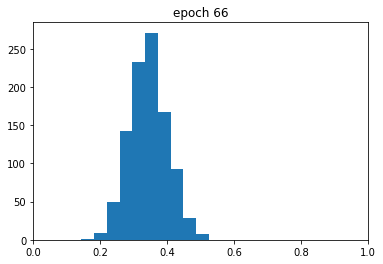

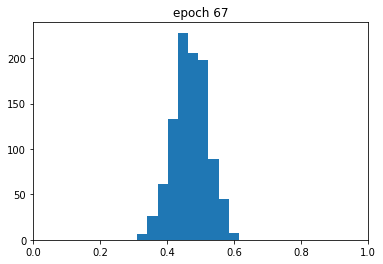

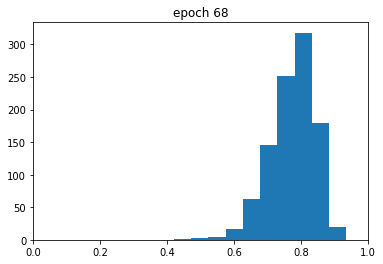

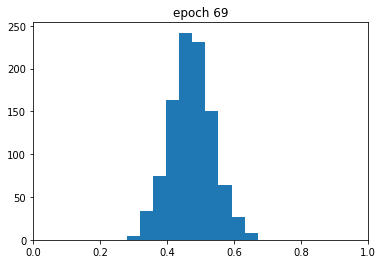

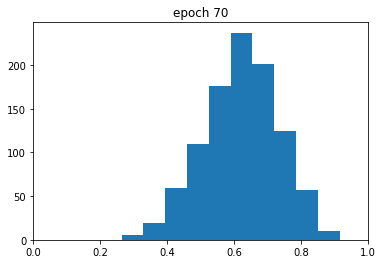

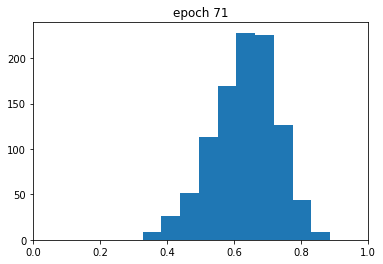

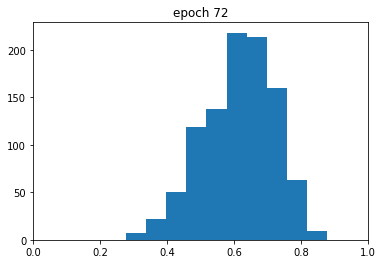

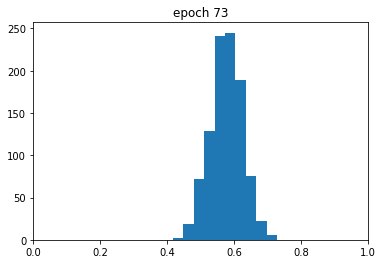

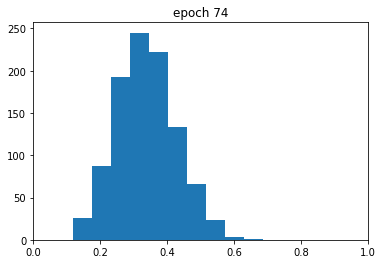

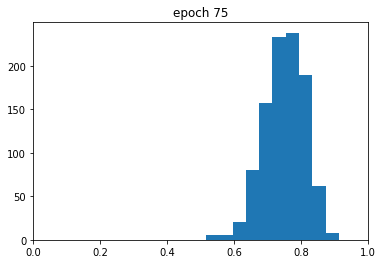

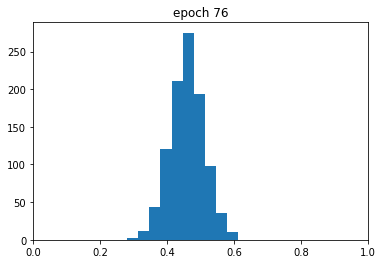

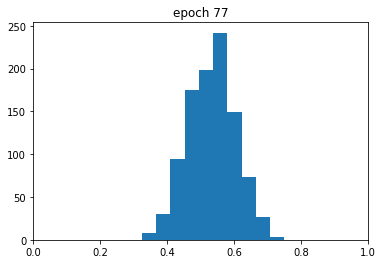

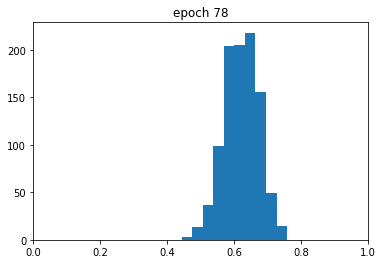

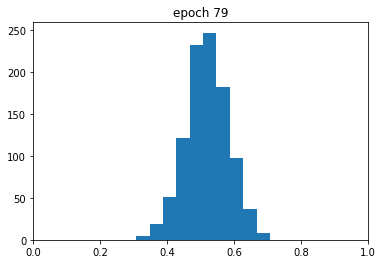

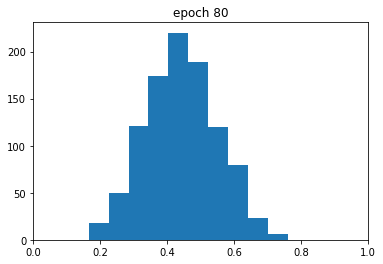

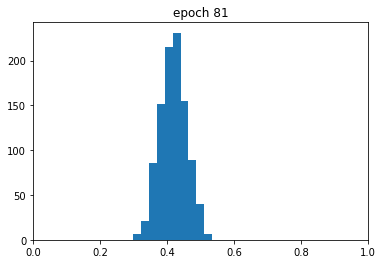

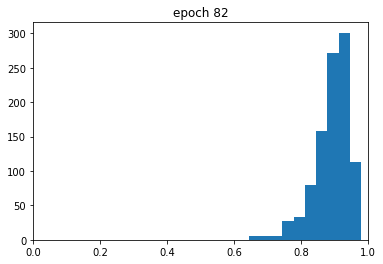

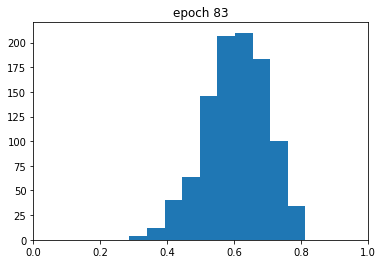

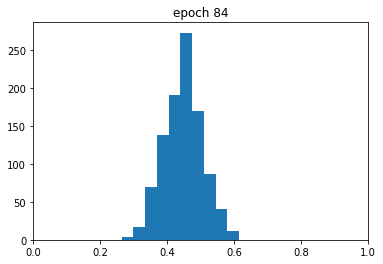

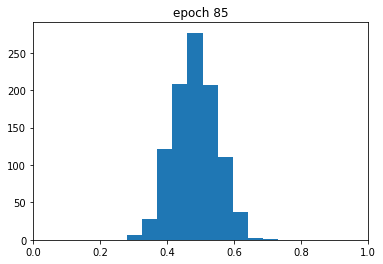

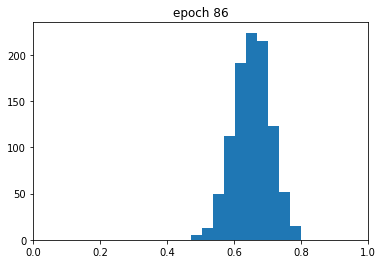

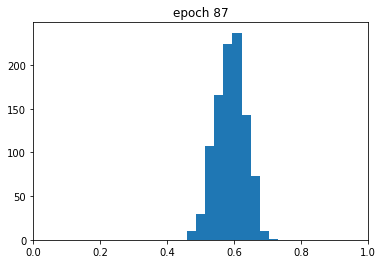

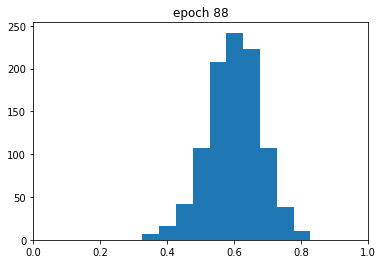

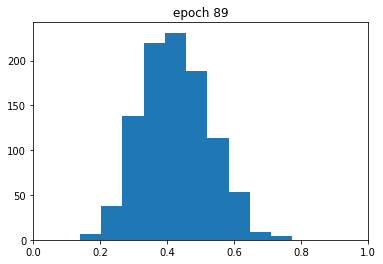

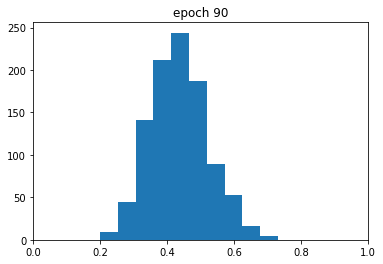

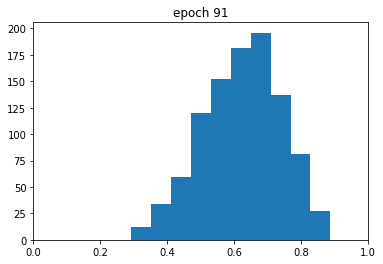

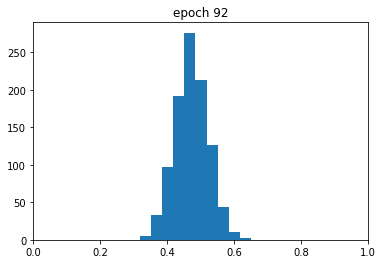

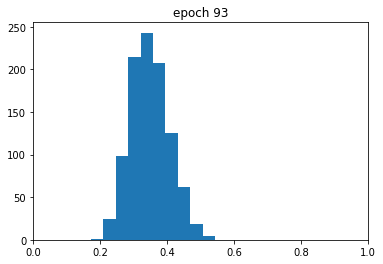

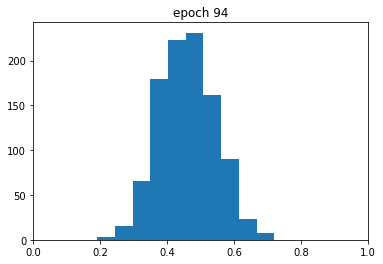

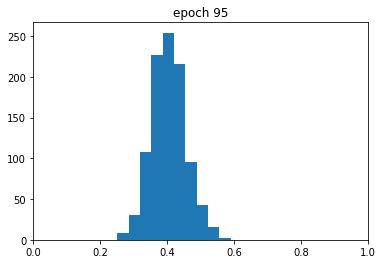

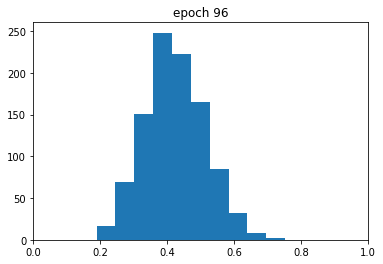

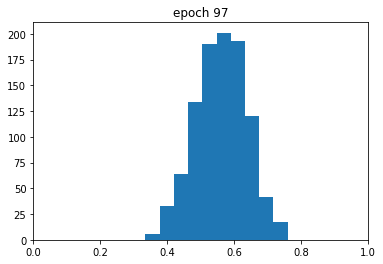

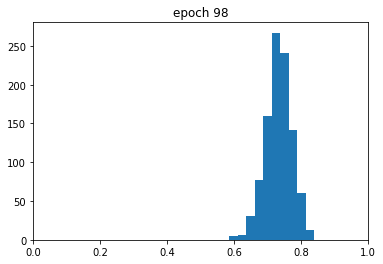

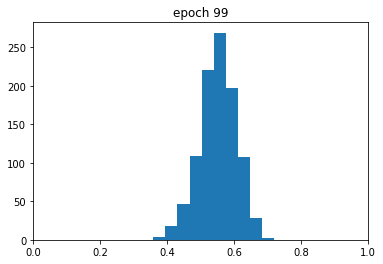

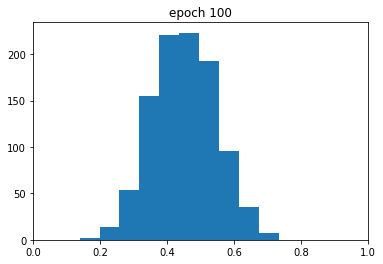

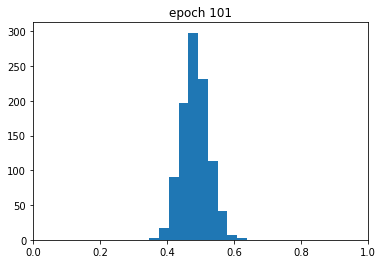

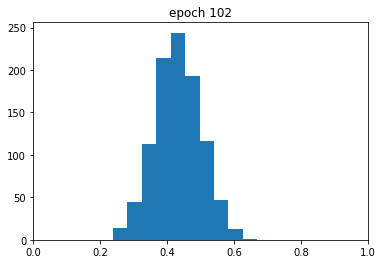

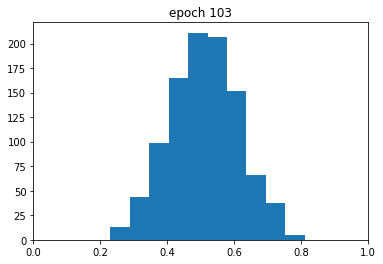

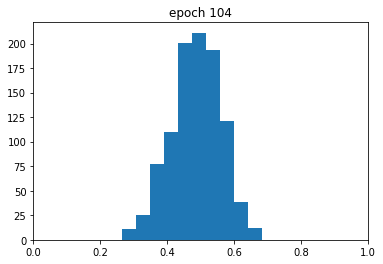

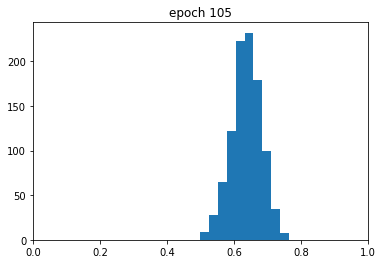

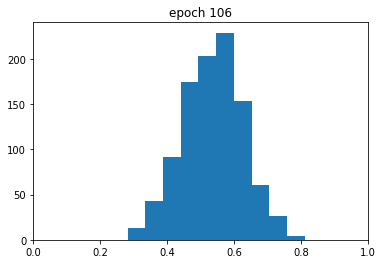

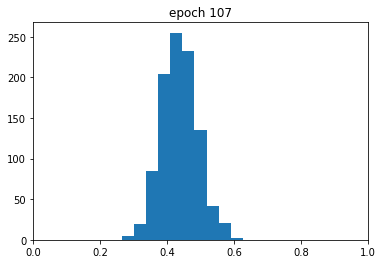

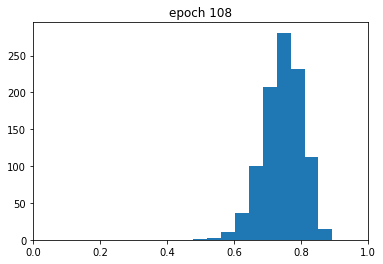

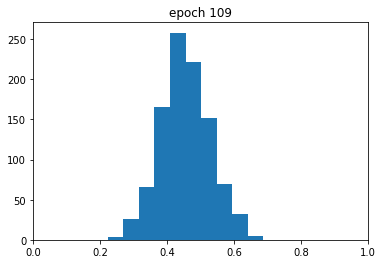

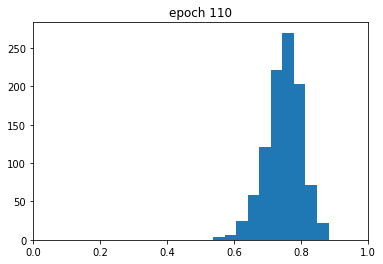

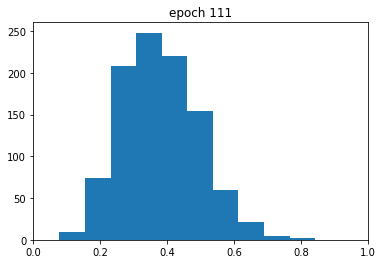

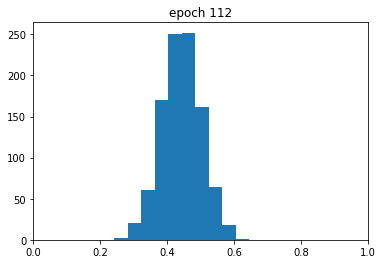

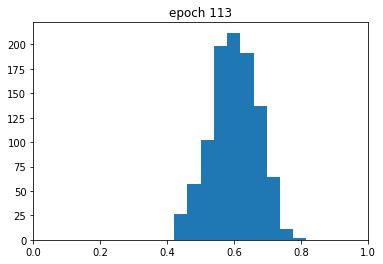

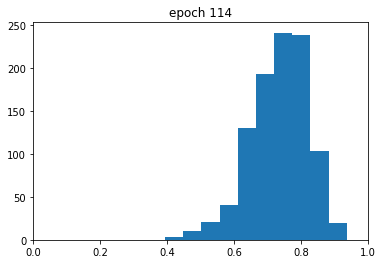

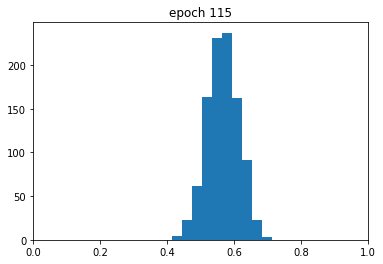

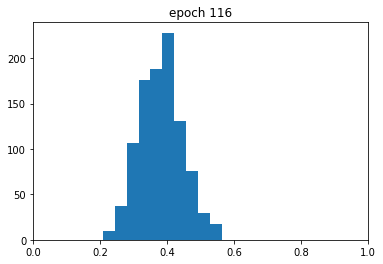

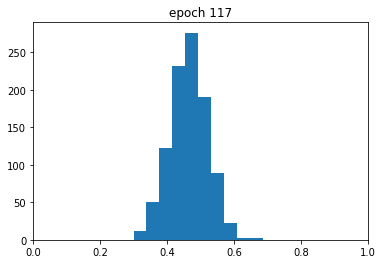

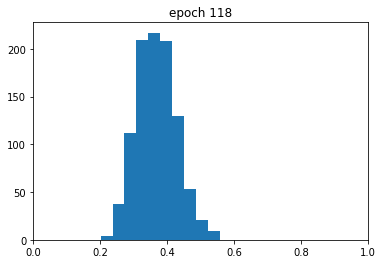

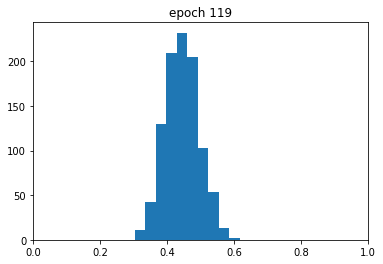

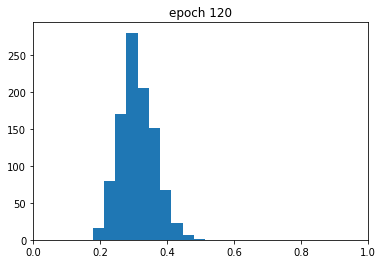

In [16]:
c = 1
for i in range(120):
    plt.hist(var_predicted[:, i])
    plt.xlim(0, 1)
    plt.title('epoch '+str(c))
    c+=1
    plt.show() # distribution of predictions

In [19]:
var_predicted.mean(axis=0), np.round(var_predicted.mean(axis=0))

(array([0.40920927, 0.40694813, 0.51912809, 0.50792596, 0.42511964,
        0.65015755, 0.53859455, 0.25954837, 0.53753193, 0.33277157,
        0.61401737, 0.42874838, 0.59168432, 0.69030561, 0.66615552,
        0.73238954, 0.63648304, 0.49990173, 0.56950884, 0.43703528,
        0.4675335 , 0.51383373, 0.46106277, 0.4144774 , 0.64257806,
        0.42107844, 0.40438487, 0.51804398, 0.29797226, 0.46864328,
        0.51153192, 0.56875778, 0.37714421, 0.38951782, 0.54071376,
        0.49713071, 0.56555956, 0.82093749, 0.49949892, 0.57742789,
        0.81444047, 0.63825069, 0.47580731, 0.45125682, 0.59779744,
        0.56578808, 0.5213304 , 0.48747167, 0.7258547 , 0.46517606,
        0.52685759, 0.57048476, 0.47893652, 0.37454192, 0.50027257,
        0.48770284, 0.61002007, 0.52426108, 0.554822  , 0.7772984 ,
        0.53979485, 0.52177045, 0.54713569, 0.52928782, 0.42341618,
        0.34428249, 0.46921912, 0.77463121, 0.47296247, 0.62147497,
        0.63212402, 0.61503239, 0.57668775, 0.33

In [21]:
submission = pd.DataFrame({'Id' : df_test['epoch'].unique().copy()})
submission['Predicted'] = np.round(var_predicted.mean(axis=0))

In [22]:
submission.to_csv('EEGNet_submission.csv', index=False)